In [44]:
import jax
from jax import lax, random
import jax.numpy as jnp
import numpy as np
import pandas as pd
import optax
import flax
import flax.linen as nn
from flax.linen import initializers
from typing import Callable, Sequence

In [96]:
class LipLinear(nn.Module):
    features: int
    use_bias: bool = True
    kernel_init: Callable = initializers.lecun_normal()
    bias_init: Callable = initializers.zeros_init()

    @nn.compact
    def __call__(self, inputs):
        kernel = self.param('kernel',
            self.kernel_init,
            (jnp.shape(inputs)[-1], self.features))
        if self.use_bias:
            bias = self.param('bias', self.bias_init, (self.features,))
        else:   bias = None
        c = self.param('c', self.bias_init, 1)
        absrowsum = jnp.sum(jnp.abs(kernel), axis=0)
        scale = jnp.minimum(1.0, nn.softplus(c)/absrowsum)
        y = lax.dot_general(inputs, kernel*scale,
                        (((inputs.ndim - 1,), (0,)), ((), ())))
        if bias is not None:
            y += jnp.reshape(bias, (1,) * (y.ndim - 1) + (-1,))
        return y

In [195]:
class LipMLP(nn.Module):
    nin: int
    features: Sequence[int]
    skip_layer: int    

    def setup(self):
        layers = []
        for i, dim in enumerate(self.features):
            if i == self.skip_layer:
                dim += self.nin
            layers += [LipLinear(dim)]
        self.layers = layers
            #= [LipLinear(feat) for feat in self.features]

    @staticmethod
    def lipschitz_loss(params):
        loss = 1.
        for layer in params['params'].keys():
            loss *= nn.softplus(params['params'][layer]['c'])
        return loss[0]
    
    def __call__(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            if i == self.skip_layer:
                x = jnp.hstack([x, inputs])
            x = layer(x)
            if i != len(self.layers) - 1:
                x = nn.leaky_relu(x)
        return x

In [196]:
model = LipMLP(2, [10, 10, 10, 10, 1], 2)

In [197]:
key1, key2 = random.split(random.PRNGKey(0))
x = random.normal(key1, (3,)) # Dummy input data
params = model.init(key2, x) # Initialization call

In [200]:
@jax.jit
def loss(params, x0, y0, x1, y1):
    # Define the squared loss for a single pair (x,y)
    def squared_error(x, y):
        pred = model.apply(params, x)
        return jnp.inner(y-pred, y-pred) / 2.0
    # Vectorize the previous to compute the average of the loss on all samples.
    x0_ = jnp.hstack([x0, jnp.zeros((x0.shape[0], 1))])
    x1_ = jnp.hstack([x1, jnp.ones((x0.shape[0], 1))])
    mse_loss0 = jnp.mean(jax.vmap(squared_error)(x0_, y0), axis=0)
    mse_loss1 = jnp.mean(jax.vmap(squared_error)(x1_, y1), axis=0)
    lip_loss = model.lipschitz_loss(params)
    return mse_loss0 + mse_loss1 + 1e-6 * lip_loss  

In [201]:
# data
df_circle = pd.read_csv("circle.csv")
x_circle = jnp.array(df_circle[["x", "y"]].to_numpy())
y_circle = jnp.array(df_circle[["d"]].to_numpy())
df_square = pd.read_csv("square.csv")
x_square = jnp.array(df_square[["x", "y"]].to_numpy())
y_square = jnp.array(df_square[["d"]].to_numpy())

# training
tx = optax.adam(learning_rate=0.001)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

In [202]:
for i in range(10000):
    loss_val, grads = loss_grad_fn(params, x_circle, y_circle, x_square, y_square)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  0.25711232
Loss step 10:  0.24767502
Loss step 20:  0.23896672
Loss step 30:  0.23038755
Loss step 40:  0.2218808
Loss step 50:  0.21343778
Loss step 60:  0.20513578
Loss step 70:  0.19705634
Loss step 80:  0.18930419
Loss step 90:  0.18195146
Loss step 100:  0.17513928
Loss step 110:  0.16906856
Loss step 120:  0.16378073
Loss step 130:  0.15940942
Loss step 140:  0.1558566
Loss step 150:  0.15314779
Loss step 160:  0.15094748
Loss step 170:  0.14886428
Loss step 180:  0.14679715
Loss step 190:  0.14453582
Loss step 200:  0.14224687
Loss step 210:  0.13990511
Loss step 220:  0.137624
Loss step 230:  0.13526699
Loss step 240:  0.13287953
Loss step 250:  0.13043515
Loss step 260:  0.12799881
Loss step 270:  0.12549908
Loss step 280:  0.12297413
Loss step 290:  0.12043692
Loss step 300:  0.11781338
Loss step 310:  0.115135856
Loss step 320:  0.11232295
Loss step 330:  0.10960936
Loss step 340:  0.106775485
Loss step 350:  0.10384978
Loss step 360:  0.1007838
Loss step 370: 

In [203]:
# Set up grid size and circle parameters
n = 50
x = jnp.linspace(-1.5,1.5,n)
y = jnp.linspace(-1.5,1.5,n)
X, Y = jnp.meshgrid(x,y)
xy = jnp.hstack([X.reshape(-1,1), Y.reshape(-1,1)])
xy0 = jnp.hstack([xy, jnp.zeros((xy.shape[0], 1))])


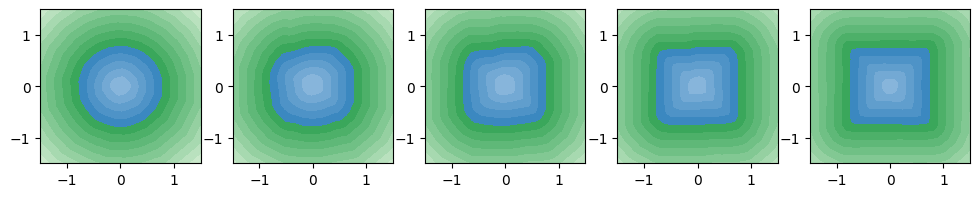

In [216]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

sdf_cm = colors.LinearSegmentedColormap.from_list('SDF', [(0,'#eff3ff'),(0.5,'#3182bd'),(0.5,'#31a354'),(1,'#e5f5e0')], N=256)

# Calculate distance function and plot

Z1 = model.apply(params, xy1).reshape(n, -1)
levels = jnp.linspace(-1.5, 1.5, 21)
fig, axes = plt.subplots(1, 5, figsize=[12, 2])
for i, ax in enumerate(axes):
    xy_ = jnp.hstack([xy, i/4*jnp.ones((xy.shape[0], 1))])
    Z = model.apply(params, xy_).reshape(n, -1)
    ax.contourf(X, Y, Z, levels=levels, cmap=sdf_cm)


plt.show()

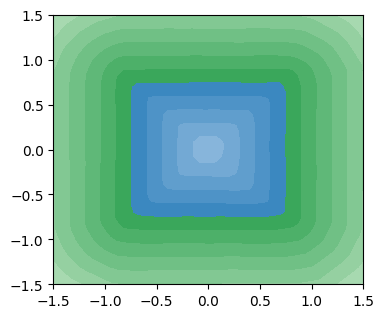

In [213]:
mid = 1
xy_ = jnp.hstack([xy, mid*jnp.ones((xy.shape[0], 1))])
Z_ = model.apply(params, xy_).reshape(n, -1)
fig, ax = plt.subplots(1, 1, figsize=[4, 3.5])
ax.contourf(X, Y, Z_, levels=levels, cmap=sdf_cm)